# Executive Summary

*** Goal *** : The goal of this project was to identify common technical indicators, strip them of their signals and explore whether a classification machine learning model could reliably predict whether the price of ETH would either gain or fall on a daily basis from these features.

*** Project Findings *** : Both the Random Forest and Logistic Regression models outperformed the Baseline with accuracies of roughly 55%.  However, the Random Forest model more reliably predicted both target outcomes with precision on both target outcomes of 55%-56%.  The Random Forest model overweighted the EMA feature which is an important component in the calculation of the 'signal' indicators which were the lowest weighted features. This suggests there is room for improvement should we incorporate the signals into the modeling. 

*** Next Steps *** : 
* Incorporate signals and fully utilize the potential impact of the 'signal' features in isolating high probability scenarios.  The noise reduction should lead to improvements in the model's predictive performance.
* Run model predictions through a simulated market environment to evaluate the model's success rate versus market return after accounting for transaction costs and potential price performance. 

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from math import floor
from math import sqrt
from scipy import stats
import prepare

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

from sklearn.model_selection import train_test_split

# for tsa 
import statsmodels.api as sm

In [3]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Acquire

In [4]:
eth = prepare.get_data()

In [5]:
eth.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188.0
1,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170.0
2,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283.0
3,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100.0
4,2015-08-12,1.058750,1.289940,0.883608,1.217440,1.217440,2150620.0


In [6]:
# check for missing/null data
eth.isnull().sum()

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

In [7]:
eth.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2116.000000,2116.000000,2116.000000,2116.000000,2116.000000,2.116000e+03
mean,345.996625,359.900218,330.685773,347.228301,347.228301,6.653876e+09
std,540.224970,566.906229,510.258962,542.654011,542.654011,1.035570e+10
min,0.431589,0.482988,0.420897,0.434829,0.434829,1.021280e+05
25%,13.281750,13.855525,13.032900,13.325150,13.325150,3.605552e+07
50%,194.705276,201.004501,187.054772,194.787369,194.787369,2.021149e+09
75%,371.200424,383.609542,363.656357,371.154121,371.154121,9.060469e+09
max,4174.635742,4362.350586,3785.848633,4168.701172,4168.701172,8.448291e+10


In [8]:
# view null rows
eth[eth['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume
1714,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN
1889,2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN
1892,2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN
1893,2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN


Note: Looks like all nulls in same rows. Considering the minimal amount of null values, I think a simple interopation would be acceptable here

# Prepare

#### Data Cleanup

In [9]:
# handle null data by interpolating missing values 
eth = eth.interpolate(method='linear')

In [10]:
eth.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2120 non-null   object 
 1   Open       2120 non-null   float64
 2   High       2120 non-null   float64
 3   Low        2120 non-null   float64
 4   Close      2120 non-null   float64
 5   Adj Close  2120 non-null   float64
 6   Volume     2120 non-null   float64
dtypes: float64(6), object(1)
memory usage: 116.1+ KB


In [12]:
# Date not in DateTime format.  Convert and set as index
eth.Date = pd.to_datetime(eth.Date)
eth = eth.set_index('Date').sort_index()

In [13]:
# compare Close and Adj Close.  Appear to be same info, need to confirm:
eth[eth['Close'] != eth['Adj Close']]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [14]:
# columns are equivalent so drop 'Adj Close'
eth = eth.drop(columns=('Adj Close'))

In [15]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2120 entries, 2015-08-08 to 2021-05-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2120 non-null   float64
 1   High    2120 non-null   float64
 2   Low     2120 non-null   float64
 3   Close   2120 non-null   float64
 4   Volume  2120 non-null   float64
dtypes: float64(5)
memory usage: 99.4 KB


In [16]:
eth.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [17]:
# drop columns that aren't going to be used as features or in feature engineering
eth = eth.drop(columns=['Open', 'High', 'Low'])

In [18]:
eth.head()

,Close,Volume
Date,,
2015-08-08,0.753325,674188.0
2015-08-09,0.701897,532170.0
2015-08-10,0.708448,405283.0
2015-08-11,1.067860,1463100.0
2015-08-12,1.217440,2150620.0


#### Feature Engineering 

In [19]:
# Create % change Day-over-Day data columns
eth['close_DoD'] = round(eth.Close.pct_change(), 2)
eth['vol_DoD'] = round(eth.Volume.pct_change(), 2)

In [20]:
# Create Close 50 & 200 day rolling averages (Close & Volume)
dfm = eth.assign(
rolling_50C=lambda eth: eth.Close.rolling(50).mean(),
rolling_200C=lambda eth: eth.Close.rolling(200).mean(),
rolling_50V=lambda eth: eth.Volume.rolling(50).mean(),
rolling_200V=lambda eth: eth.Volume.rolling(200).mean())

In [21]:
def EMA(df, period, column):
    return df[column].ewm(span=period, adjust=False).mean()

In [22]:
def RSI(df, period):
    window_length= period
    # Dates
    start = df.index.min()
    end = df.index.max()
    # Get the difference in price from previous step
    delta = df.Close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous 
    # row to calculate the differences
    delta = delta[1:]
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0)
    # Calculate the EWMA
    roll_up1 = up.ewm(span=window_length).mean()
    roll_down1 = down.abs().ewm(span=window_length).mean()

    # Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI = 100.0 - (100.0 / (1.0 + RS1))
    
    df['RSI'+str(period)] = RSI
    return df

In [23]:
# run functions to add indicator features
prepare.indicators(dfm)

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI12,RSI26,EMA7,EMA12,EMA26,momentum-cross
Date,,,,,,,,,,,,,,,
2015-08-08,0.753325,6.741880e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.753325,0.753325,0.753325,NaN
2015-08-09,0.701897,5.321700e+05,-0.07,-0.21,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.740468,0.745413,0.749516,NaN
2015-08-10,0.708448,4.052830e+05,0.01,-0.24,NaN,NaN,NaN,NaN,14.518417,13.084467,12.093517,0.732463,0.739726,0.746473,NaN
2015-08-11,1.067860,1.463100e+06,0.51,2.61,NaN,NaN,NaN,NaN,92.643867,90.835392,89.234726,0.816312,0.790208,0.770280,NaN
2015-08-12,1.217440,2.150620e+06,0.14,0.47,NaN,NaN,NaN,NaN,95.119189,93.635631,92.279805,0.916594,0.855936,0.803403,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23,2109.579834,5.600572e+10,-0.08,0.33,2787.276658,1582.527753,4.196180e+10,3.013594e+10,18.430450,24.147085,34.381818,2634.165140,2891.064501,3015.199330,1.76
2021-05-24,2643.591064,5.369712e+10,0.25,-0.04,2798.286023,1593.675372,4.251561e+10,3.032722e+10,50.345309,43.950537,44.588112,2636.521621,2852.991665,2987.672792,1.76
2021-05-25,2706.628906,4.955833e+10,0.02,-0.08,2810.260857,1604.934920,4.292899e+10,3.049132e+10,53.225765,45.920259,45.665553,2654.048442,2830.474317,2966.854726,1.75


In [24]:
dfm.head()

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI12,RSI26,EMA7,EMA12,EMA26,momentum-cross
Date,,,,,,,,,,,,,,,
2015-08-08,0.753325,674188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.753325,0.753325,0.753325,NaN
2015-08-09,0.701897,532170.0,-0.07,-0.21,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.740468,0.745413,0.749516,NaN
2015-08-10,0.708448,405283.0,0.01,-0.24,NaN,NaN,NaN,NaN,14.518417,13.084467,12.093517,0.732463,0.739726,0.746473,NaN
2015-08-11,1.067860,1463100.0,0.51,2.61,NaN,NaN,NaN,NaN,92.643867,90.835392,89.234726,0.816312,0.790208,0.770280,NaN
2015-08-12,1.217440,2150620.0,0.14,0.47,NaN,NaN,NaN,NaN,95.119189,93.635631,92.279805,0.916594,0.855936,0.803403,NaN


In [25]:
# Add Crossover indicator (rollling 50 vs rolling 200)
dfm['momentum-cross'] = round(dfm.rolling_50C/dfm.rolling_200C, 2)

In [26]:
dfm.tail()

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI12,RSI26,EMA7,EMA12,EMA26,momentum-cross
Date,,,,,,,,,,,,,,,
2021-05-23,2109.579834,5.600572e+10,-0.08,0.33,2787.276658,1582.527753,4.196180e+10,3.013594e+10,18.430450,24.147085,34.381818,2634.165140,2891.064501,3015.199330,1.76
2021-05-24,2643.591064,5.369712e+10,0.25,-0.04,2798.286023,1593.675372,4.251561e+10,3.032722e+10,50.345309,43.950537,44.588112,2636.521621,2852.991665,2987.672792,1.76
2021-05-25,2706.628906,4.955833e+10,0.02,-0.08,2810.260857,1604.934920,4.292899e+10,3.049132e+10,53.225765,45.920259,45.665553,2654.048442,2830.474317,2966.854726,1.75
2021-05-26,2888.698730,4.249977e+10,0.07,-0.14,2825.667253,1617.199848,4.319453e+10,3.060946e+10,61.766904,51.712604,48.772639,2712.711014,2839.431919,2961.065393,1.75
2021-05-27,2776.133057,3.456504e+10,-0.04,-0.19,2841.768369,1628.812739,4.316350e+10,3.072582e+10,53.685726,47.959319,46.978847,2728.566525,2829.693633,2947.366701,1.74


In [27]:
# Add On Balance Volume indicator
def obv(df):  
    obv = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df['OBV'] = round(obv, 0)
    return df

In [28]:
# Execute obv function:
prepare.obv(dfm)

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI12,RSI26,EMA7,EMA12,EMA26,momentum-cross,OBV
Date,,,,,,,,,,,,,,,,
2015-08-08,0.753325,6.741880e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.753325,0.753325,0.753325,NaN,0.000000e+00
2015-08-09,0.701897,5.321700e+05,-0.07,-0.21,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.740468,0.745413,0.749516,NaN,-5.321700e+05
2015-08-10,0.708448,4.052830e+05,0.01,-0.24,NaN,NaN,NaN,NaN,14.518417,13.084467,12.093517,0.732463,0.739726,0.746473,NaN,-1.268870e+05
2015-08-11,1.067860,1.463100e+06,0.51,2.61,NaN,NaN,NaN,NaN,92.643867,90.835392,89.234726,0.816312,0.790208,0.770280,NaN,1.336213e+06
2015-08-12,1.217440,2.150620e+06,0.14,0.47,NaN,NaN,NaN,NaN,95.119189,93.635631,92.279805,0.916594,0.855936,0.803403,NaN,3.486833e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23,2109.579834,5.600572e+10,-0.08,0.33,2787.276658,1582.527753,4.196180e+10,3.013594e+10,18.430450,24.147085,34.381818,2634.165140,2891.064501,3015.199330,1.76,1.403957e+12
2021-05-24,2643.591064,5.369712e+10,0.25,-0.04,2798.286023,1593.675372,4.251561e+10,3.032722e+10,50.345309,43.950537,44.588112,2636.521621,2852.991665,2987.672792,1.76,1.457654e+12
2021-05-25,2706.628906,4.955833e+10,0.02,-0.08,2810.260857,1604.934920,4.292899e+10,3.049132e+10,53.225765,45.920259,45.665553,2654.048442,2830.474317,2966.854726,1.75,1.507212e+12


In [29]:
dfm.head()

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI12,RSI26,EMA7,EMA12,EMA26,momentum-cross,OBV
Date,,,,,,,,,,,,,,,,
2015-08-08,0.753325,674188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.753325,0.753325,0.753325,NaN,0.0
2015-08-09,0.701897,532170.0,-0.07,-0.21,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.740468,0.745413,0.749516,NaN,-532170.0
2015-08-10,0.708448,405283.0,0.01,-0.24,NaN,NaN,NaN,NaN,14.518417,13.084467,12.093517,0.732463,0.739726,0.746473,NaN,-126887.0
2015-08-11,1.067860,1463100.0,0.51,2.61,NaN,NaN,NaN,NaN,92.643867,90.835392,89.234726,0.816312,0.790208,0.770280,NaN,1336213.0
2015-08-12,1.217440,2150620.0,0.14,0.47,NaN,NaN,NaN,NaN,95.119189,93.635631,92.279805,0.916594,0.855936,0.803403,NaN,3486833.0


In [30]:
# Calculate Moving Average Convergence/Divergence
exp1 = dfm.Close.ewm(span=12, adjust=False).mean()
exp2 = dfm.Close.ewm(span=26, adjust=False).mean()
dfm['macd'] = exp1 - exp2

In [31]:
dfm.head()

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI12,RSI26,EMA7,EMA12,EMA26,momentum-cross,OBV,macd
Date,,,,,,,,,,,,,,,,,
2015-08-08,0.753325,674188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.753325,0.753325,0.753325,NaN,0.0,0.000000
2015-08-09,0.701897,532170.0,-0.07,-0.21,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.740468,0.745413,0.749516,NaN,-532170.0,-0.004103
2015-08-10,0.708448,405283.0,0.01,-0.24,NaN,NaN,NaN,NaN,14.518417,13.084467,12.093517,0.732463,0.739726,0.746473,NaN,-126887.0,-0.006747
2015-08-11,1.067860,1463100.0,0.51,2.61,NaN,NaN,NaN,NaN,92.643867,90.835392,89.234726,0.816312,0.790208,0.770280,NaN,1336213.0,0.019928
2015-08-12,1.217440,2150620.0,0.14,0.47,NaN,NaN,NaN,NaN,95.119189,93.635631,92.279805,0.916594,0.855936,0.803403,NaN,3486833.0,0.052533


#### Create the target variable.  In this case, we are going look forward one day and determine whether the Close is higher or lower for our model to reference against the current observations

In [32]:
# Calculate and add Target +/- column
dfm['up_down'] = np.where(dfm.Close.shift(-1) > dfm.Close, 1, 0) 

In [33]:
dfm.head(5)

,Close,Volume,close_DoD,vol_DoD,rolling_50C,rolling_200C,rolling_50V,rolling_200V,RSI7,RSI12,RSI26,EMA7,EMA12,EMA26,momentum-cross,OBV,macd,up_down
Date,,,,,,,,,,,,,,,,,,
2015-08-08,0.753325,674188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.753325,0.753325,0.753325,NaN,0.0,0.000000,0
2015-08-09,0.701897,532170.0,-0.07,-0.21,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.740468,0.745413,0.749516,NaN,-532170.0,-0.004103,1
2015-08-10,0.708448,405283.0,0.01,-0.24,NaN,NaN,NaN,NaN,14.518417,13.084467,12.093517,0.732463,0.739726,0.746473,NaN,-126887.0,-0.006747,1
2015-08-11,1.067860,1463100.0,0.51,2.61,NaN,NaN,NaN,NaN,92.643867,90.835392,89.234726,0.816312,0.790208,0.770280,NaN,1336213.0,0.019928,1
2015-08-12,1.217440,2150620.0,0.14,0.47,NaN,NaN,NaN,NaN,95.119189,93.635631,92.279805,0.916594,0.855936,0.803403,NaN,3486833.0,0.052533,1


In [34]:
# Cull the first full year off of my df so in order to eliminate NaN
dfm.index.min(), dfm.index.max()

(Timestamp('2015-08-08 00:00:00'), Timestamp('2021-05-27 00:00:00'))

In [35]:
dfm = dfm['2017':]

In [36]:
# Control check
dfm.index.min()

Timestamp('2017-01-01 00:00:00')

In [37]:
dfm.isna().sum()

Close             0
Volume            0
close_DoD         0
vol_DoD           0
rolling_50C       0
rolling_200C      0
rolling_50V       0
rolling_200V      0
RSI7              0
RSI12             0
RSI26             0
EMA7              0
EMA12             0
EMA26             0
momentum-cross    0
OBV               0
macd              0
up_down           0
dtype: int64

# Data Split

In [38]:
def split_data():
    '''
    take in a DataFrame and return train, validate, and test DataFrames; stratify on survived.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(dfm, test_size=.2, random_state=123, stratify=dfm.up_down)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123, 
                                       stratify=train_validate.up_down)
    return train, validate, test

In [39]:
train, validate, test = split_data()

In [40]:
# Validate split

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')


train -> (900, 18)
validate -> (386, 18)
test -> (322, 18)


# Explore

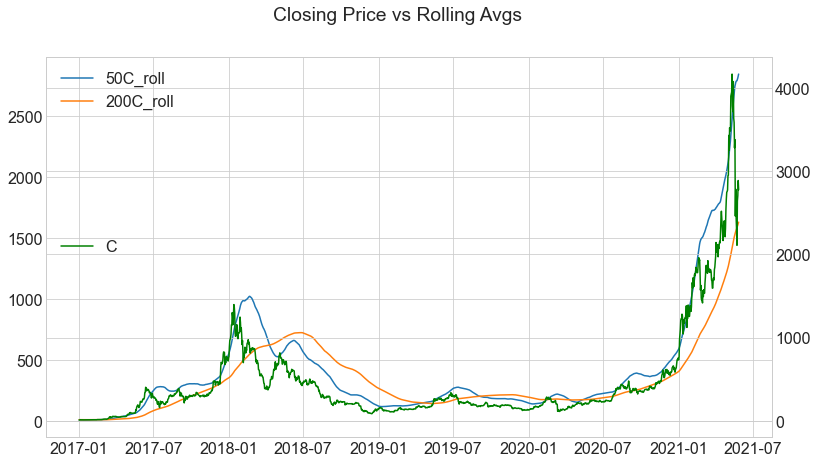

In [61]:
# Close vs rolling Volumes
fig,ax = plt.subplots()
fig.suptitle('Closing Price vs Rolling Avgs')
ax.plot(dfm[['rolling_50C', 'rolling_200C']])
plt.legend(['50C_roll', '200C_roll'])
ax2=ax.twinx()
ax2.plot(dfm.Close, color='green')
plt.legend('Close', loc='center left')

Observation: the relationship between the 50C and 200C moving averages appear to correspond with longer trend reversals
* in order to try and capture this and incorporate into model, create feature that is a ratio between the two
* weighted moving average metrics should help capture similar short term dynamics

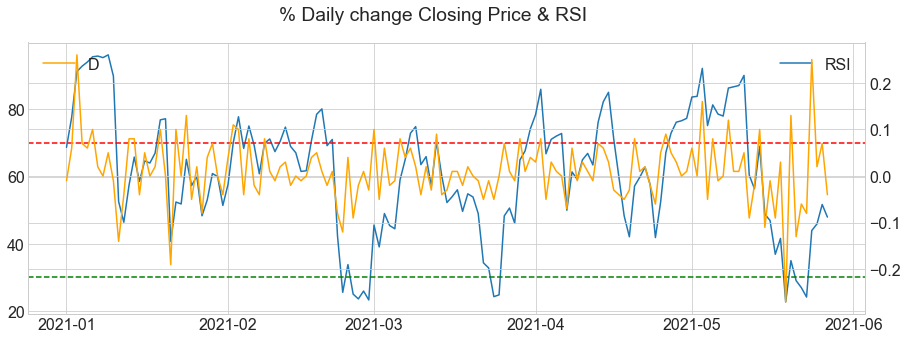

In [62]:
# View RSI Indicator and compare vs Close price
fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('% Daily change Closing Price & RSI')
ax.plot(dfm.RSI12['2021':])
plt.axhline(y = 70, color ="red", linestyle ="--")
plt.axhline(y = 30, color ="green", linestyle ="--")
plt.legend(['RSI'])
ax2=ax.twinx()
ax2.plot(dfm['2021':].close_DoD, color='orange')
plt.legend('DoD', loc ='upper left')

Observation: 

* RSI indicator and daily delta on Close ('Price') appear to largely move in line with each other.  Large swings in RSI tend to be associated with large daily changes in closing prices.
* RSI & Day-over-day price change confluence occurs between within the RSI 50-70 range. Price volatility is least volatile here.  Price volatility sharply increases as the RSI indicator exits the 50-70 range. 

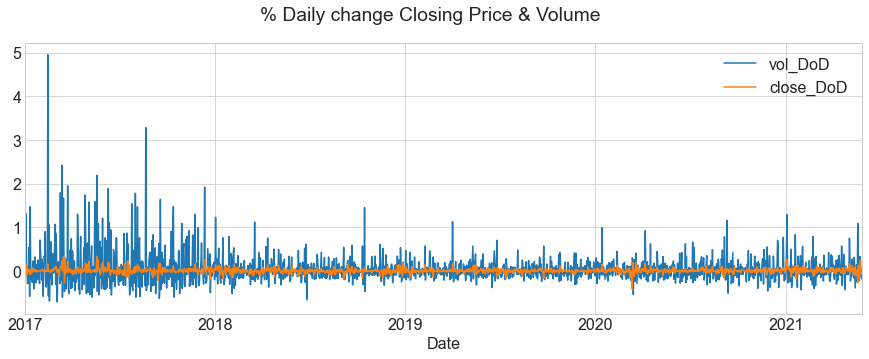

In [43]:
fig, axes = plt.subplots(1, 1,figsize=(15,5))
fig.suptitle('% Daily change Closing Price & Volume')
dfm['vol_DoD'].plot()
dfm['close_DoD'].plot()
plt.legend()

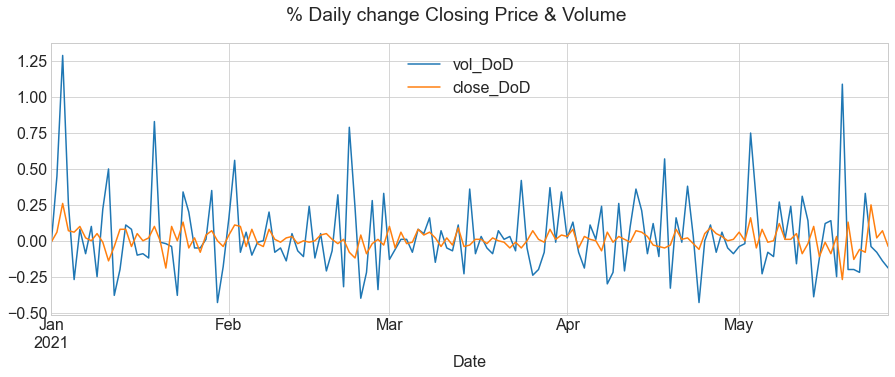

In [44]:
fig, axes = plt.subplots(1, 1,figsize=(15,5))
fig.suptitle('% Daily change Closing Price & Volume')
dfm['2021':]['vol_DoD'].plot()
dfm['2021':]['close_DoD'].plot()
plt.legend()

Observation: on the longer data timeline it was hard to identify some connection b/w price and volume but there definitely appears to be one after zooming in a bit with large changes in volume associated with larger daily changes in price.  
* the direction of the movements in volume and closing prices aren't always the same

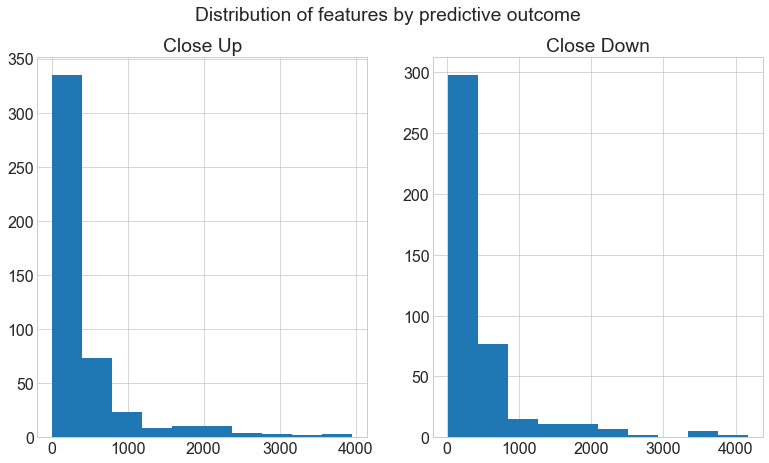

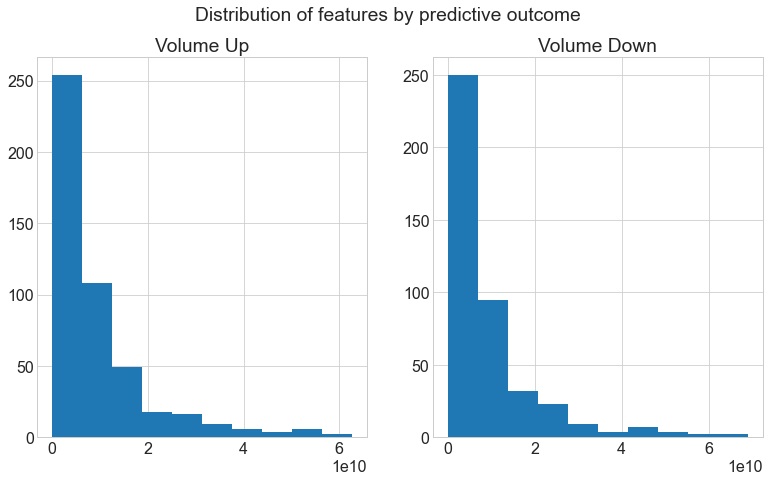

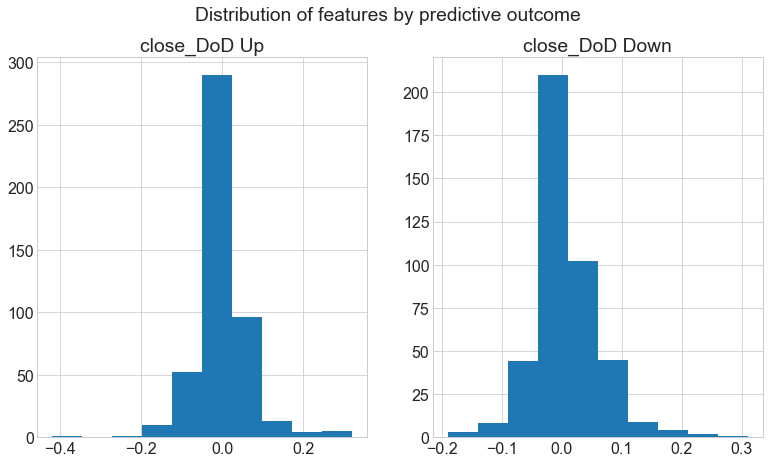

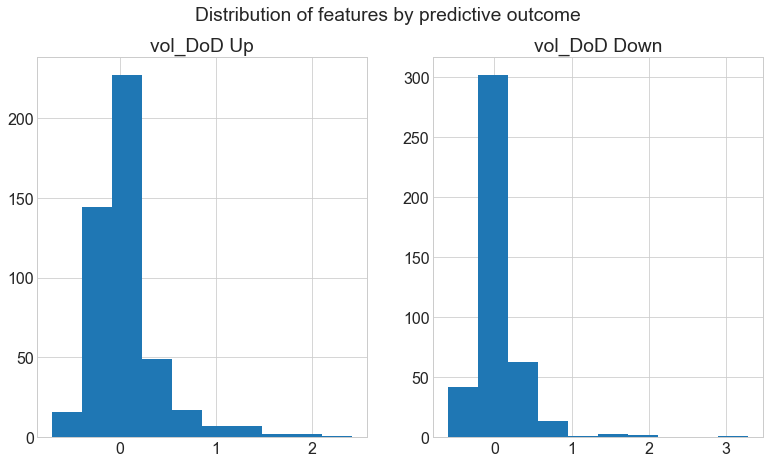

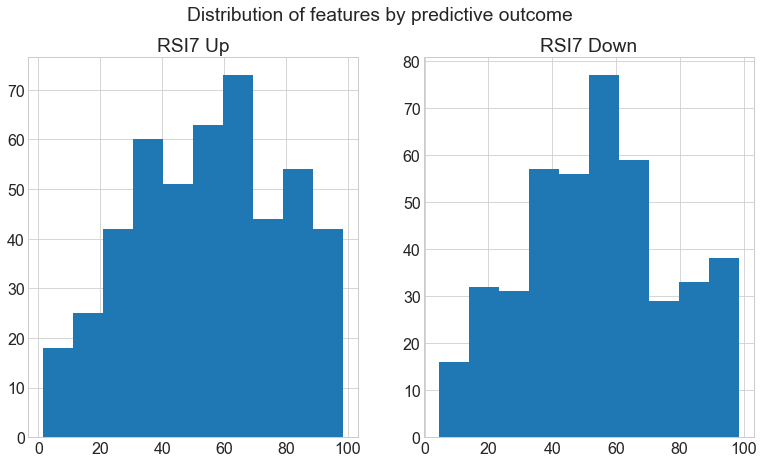

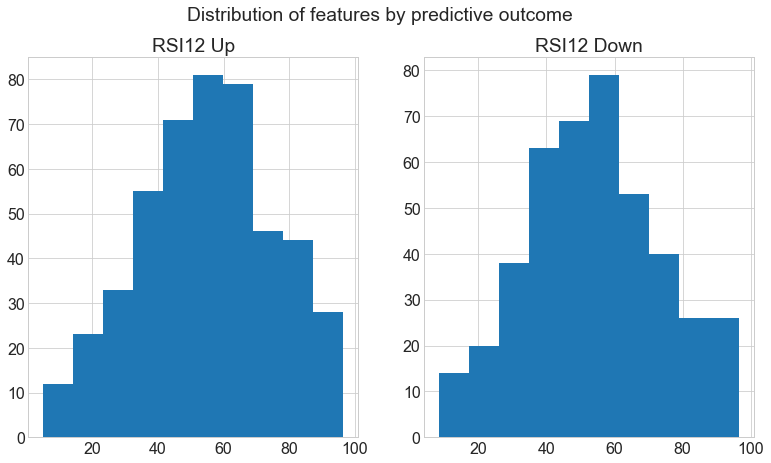

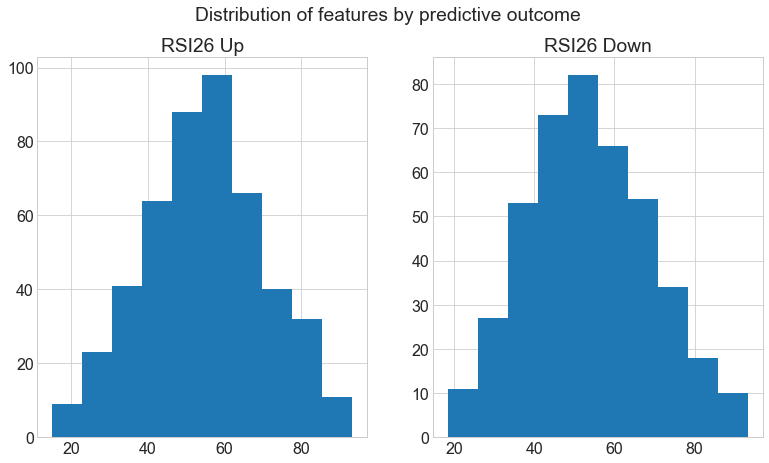

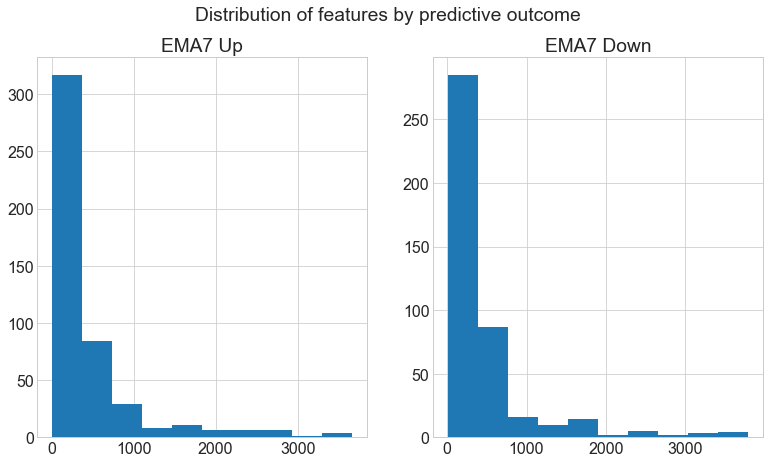

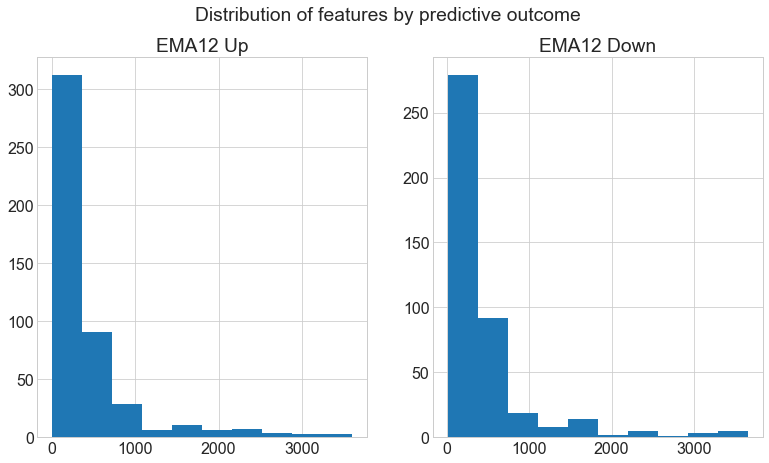

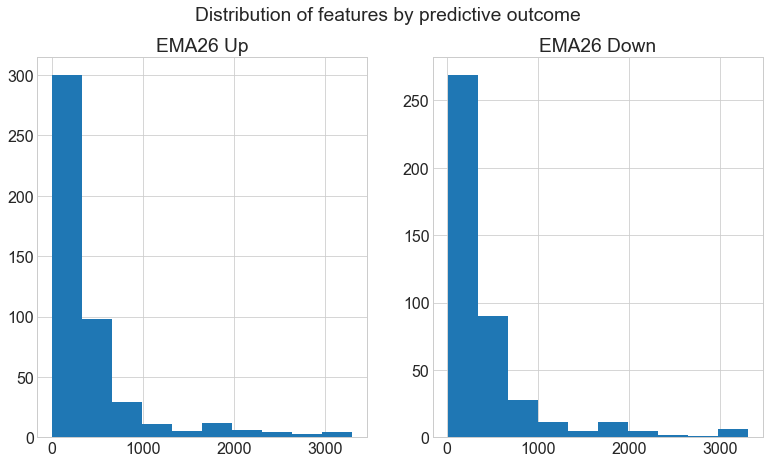

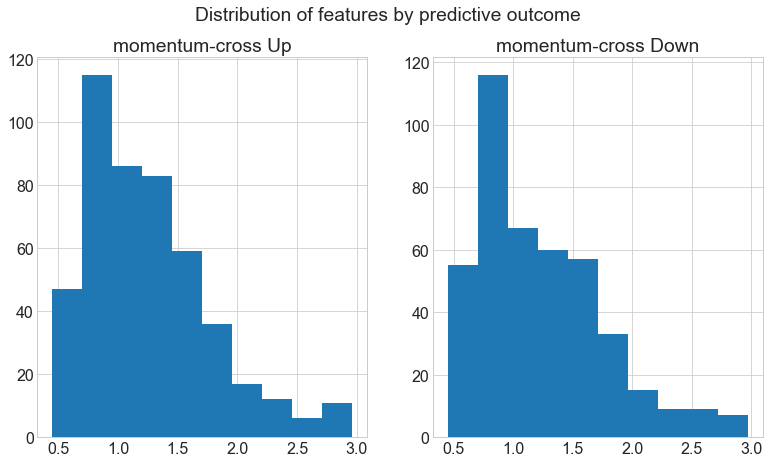

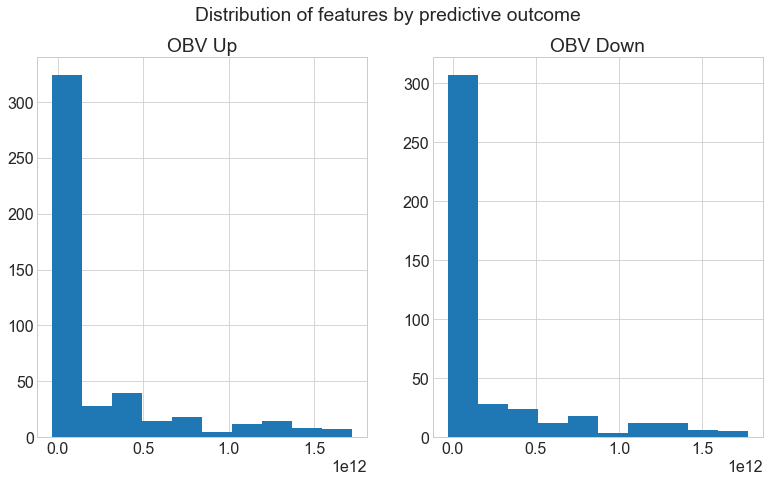

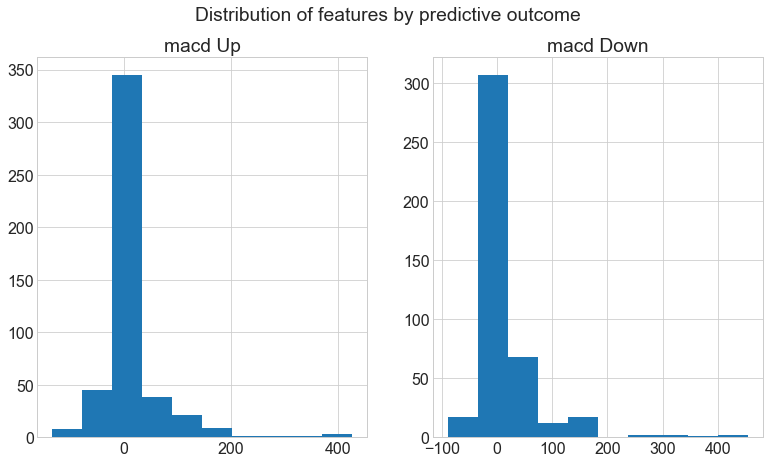

In [50]:
features = ['Close', 'Volume', 'close_DoD', 'vol_DoD', 'RSI7', 'RSI12', 'RSI26', 'EMA7', 'EMA12', 'EMA26', 'momentum-cross', 'OBV', 'macd']
for feature in features:
    plt.subplot(121)
    plt.suptitle('Distribution of features by predictive outcome')
    plt.hist(train[train.up_down == 1][feature])
    plt.title(feature + str(' Up'))
    plt.subplot(122)
    plt.hist(train[train.up_down == 0][feature])
    plt.title(feature + str(' Down'))
    plt.show()

Observation: Data appears to be normally distributed. 

# Hypothesis Testing

In [46]:
# Begin by separating the train data into up/down subgroupings

up = train[train.up_down == 1]
down = train[train.up_down == 0]

In [47]:
# Identify features for hypothesis testing
[col for col in train.columns]

['Close',
 'Volume',
 'close_DoD',
 'vol_DoD',
 'rolling_50C',
 'rolling_200C',
 'rolling_50V',
 'rolling_200V',
 'RSI7',
 'RSI12',
 'RSI26',
 'EMA7',
 'EMA12',
 'EMA26',
 'momentum-cross',
 'OBV',
 'macd',
 'up_down']

In [48]:
features = ['Close', 'Volume', 'close_DoD', 'vol_DoD', 'RSI7', 'RSI12', 'RSI26', 'EMA7', 'EMA12', 'EMA26', 'momentum-cross', 'OBV', 'macd']

Null and alternative hypotheses 

$H_0$: there is no significant relationship between target and feature

$H_a$: there is a significant relationship between target and feature

Alpha = 0.05

In [49]:
# T-test and significance level for all features vs target
for feature in features:
    print(feature)
    print(stats.mannwhitneyu(up[feature], down[feature], alternative='two-sided'))
    

Close
MannwhitneyuResult(statistic=96625.0, pvalue=0.26047405887032926)
Volume
MannwhitneyuResult(statistic=100684.0, pvalue=0.9338011392492952)
close_DoD
MannwhitneyuResult(statistic=90095.0, pvalue=0.00492521458005248)
vol_DoD
MannwhitneyuResult(statistic=98968.0, pvalue=0.6004572033882556)
RSI7
MannwhitneyuResult(statistic=103966.0, pvalue=0.4476242887410917)
RSI12
MannwhitneyuResult(statistic=105326.0, pvalue=0.26761069300215523)
RSI26
MannwhitneyuResult(statistic=105486.0, pvalue=0.25028228070904657)
EMA7
MannwhitneyuResult(statistic=96927.0, pvalue=0.2947637481053167)
EMA12
MannwhitneyuResult(statistic=96811.0, pvalue=0.28125108790792097)
EMA26
MannwhitneyuResult(statistic=96534.0, pvalue=0.2507057113673947)
momentum-cross
MannwhitneyuResult(statistic=106678.0, pvalue=0.14544492980161938)
OBV
MannwhitneyuResult(statistic=100594.0, pvalue=0.9154457194647944)
macd
MannwhitneyuResult(statistic=103011.0, pvalue=0.6071322009124329)


In [50]:
model_features = ['close_DoD', 'vol_DoD', 'RSI7', 'RSI12', 'RSI26', 'EMA7', 'EMA12', 'EMA26', 'momentum-cross', 'OBV', 'macd']

***
Conclusion:

* I can reject the null hypothesis and establish that there is a signficant relationship between my two 'observed delta' features and my up_down target
    * I can not reject the null hypothesis for Close & Volume alone; no significant relationship
* My engineered feature samples do not meet my confidence interval allowing me to reject the null hypothesis
    * However, not as surprising as initially thought considering these features are constructed from and dependent on prior observations irrespective of target population 
***

# Model Construction

In [89]:
# pare down features
[col for col in train.columns]

['Close',
 'Volume',
 'close_DoD',
 'vol_DoD',
 'rolling_50C',
 'rolling_200C',
 'rolling_50V',
 'rolling_200V',
 'RSI7',
 'RSI12',
 'RSI26',
 'EMA7',
 'EMA12',
 'EMA26',
 'momentum-cross',
 'OBV',
 'macd',
 'up_down']

In [337]:
#  create X & y version of train, where y is a series with just the target feature and X are all the features. 

X_train = train.drop(columns=['up_down', 'Close', 'Volume', 'rolling_50C', 'rolling_200C', 'rolling_50V', 'rolling_200V'])
y_train = train.up_down

X_validate = validate.drop(columns=['up_down', 'Close', 'Volume', 'rolling_50C', 'rolling_200C', 'rolling_50V', 'rolling_200V'])
y_validate = validate.up_down

X_test = test.drop(columns=['up_down', 'Close', 'Volume', 'rolling_50C', 'rolling_200C', 'rolling_50V', 'rolling_200V'])
y_test = test.up_down

In [338]:
# Confirm splits
print(f'train -> {X_train.shape, y_train.shape}')
print(f'validate -> {X_validate.shape, y_validate.shape}')
print(f'test -> {X_test.shape, y_test.shape}')

train -> ((900, 11), (900,))
validate -> ((386, 11), (386,))
test -> ((322, 11), (322,))


*** Establish Baseline ***

In [339]:
mode = dfm.up_down.mode()
mode

0    1
dtype: int64

In [340]:
baseline = len(train[train.up_down == 1]) / len(train)
print(f'My baseline accuracy is {round(baseline * 100,2)} %.')

My baseline accuracy is 52.44 %.


***
Decision Tree
***

In [341]:
# Imports
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [342]:
# Set Decision Tree hyperparameters
clf = DecisionTreeClassifier(max_depth=8, random_state=123)

In [343]:
# Fit the random forest algorithm to the training data.
clf = clf.fit(X_train, y_train)

In [344]:
# make prediction on train obeservations
y_pred = clf.predict(X_train)

In [345]:
# Feature importance
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.44134078, 0.55865922],
       [0.25806452, 0.74193548],
       [0.        , 1.        ],
       ...,
       [0.44134078, 0.55865922],
       [0.55223881, 0.44776119],
       [0.83333333, 0.16666667]])

In [346]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.72


In [347]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       428
           1       0.74      0.73      0.73       472

    accuracy                           0.72       900
   macro avg       0.72      0.72      0.72       900
weighted avg       0.72      0.72      0.72       900



In [348]:
print('Accuracy of Decision Tree classifier on Validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on Validate set: 0.52


In [349]:
# Produce y_predictions that come from the X_validate
y_predv = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_predv))

              precision    recall  f1-score   support

           0       0.49      0.45      0.47       184
           1       0.54      0.58      0.56       202

    accuracy                           0.52       386
   macro avg       0.52      0.52      0.51       386
weighted avg       0.52      0.52      0.52       386



***
Random Forest
***

In [350]:
# imports
from sklearn.ensemble import RandomForestClassifier

In [351]:
# Set Random Forest hyperparameters
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=10,
                            max_depth=3, 
                            random_state=123)


In [352]:
# Fit the model to the Train data
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, n_estimators=10,
                       random_state=123)

In [353]:
# Feature importance as determined by model
print(rf.feature_importances_)

[0.10767387 0.09275677 0.06153515 0.07931872 0.07724859 0.10804961
 0.17429567 0.08941296 0.10233362 0.01831008 0.08906496]


In [354]:
feature_list = [
 'close_DoD',
 'vol_DoD',
 'RSI7',
 'RSI12',
 'RSI26',
 'EMA7',
 'EMA12',
 'EMA26',
 'momentum-cross',
 'OBV',
 'macd']

In [355]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: EMA12                Importance: 0.17
Variable: close_DoD            Importance: 0.11
Variable: EMA7                 Importance: 0.11
Variable: momentum-cross       Importance: 0.1
Variable: vol_DoD              Importance: 0.09
Variable: EMA26                Importance: 0.09
Variable: macd                 Importance: 0.09
Variable: RSI12                Importance: 0.08
Variable: RSI26                Importance: 0.08
Variable: RSI7                 Importance: 0.06
Variable: OBV                  Importance: 0.02


[None, None, None, None, None, None, None, None, None, None, None]

In [356]:
# Make predictions
y_pred_rf = rf.predict(X_train)

In [357]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.63


In [358]:
# Classification report
print(classification_report(y_train, y_pred_rf))

              precision    recall  f1-score   support

           0       0.66      0.47      0.55       428
           1       0.62      0.78      0.69       472

    accuracy                           0.63       900
   macro avg       0.64      0.63      0.62       900
weighted avg       0.64      0.63      0.62       900



In [359]:
# Compute the accuracy of the model when run on the validate dataset.

print('Accuracy of random forest classifier on Validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on Validate set: 0.55


In [360]:
# Produce y_predictions that come from the X_validate
y_pred_rfv = rf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred_rfv))

              precision    recall  f1-score   support

           0       0.55      0.38      0.45       184
           1       0.56      0.72      0.63       202

    accuracy                           0.55       386
   macro avg       0.55      0.55      0.54       386
weighted avg       0.55      0.55      0.54       386



***
Logistic Regression
***

In [361]:
# imports
from sklearn.linear_model import LogisticRegression

In [362]:
# Set logit hyperparameters
logit = LogisticRegression(C=1, class_weight={0:1, 1:1}, random_state=123, intercept_scaling=True, solver='lbfgs')

In [363]:
# Fit the model
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 1, 1: 1}, intercept_scaling=True,
                   random_state=123)

In [364]:
# Feature importance
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-1.30467379e-25  1.15364004e-25  6.82915643e-23  7.12071753e-23
   6.86201707e-23 -1.16049865e-22 -1.04556095e-22 -6.37872082e-23
   1.71068721e-24  1.67679618e-13 -4.07688868e-23]]
Intercept: 
 [1.02377131e-24]


In [365]:
# Make Predictions
y_predlog = logit.predict(X_train)

In [366]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.51


In [367]:
# Classification report
print(classification_report(y_train, y_predlog))

              precision    recall  f1-score   support

           0       0.45      0.19      0.26       428
           1       0.52      0.79      0.63       472

    accuracy                           0.51       900
   macro avg       0.49      0.49      0.45       900
weighted avg       0.49      0.51      0.45       900



In [368]:
# Compute the accuracy of the model when run on the validate dataset.

print('Accuracy of Logistic Regression on Validate set: {:.2f}'
     .format(logit.score(X_validate, y_validate)))

Accuracy of Logistic Regression on Validate set: 0.54


In [369]:
# Produce y_predictions that come from the X_validate
y_predlog_v = logit.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_predlog_v))

              precision    recall  f1-score   support

           0       0.54      0.21      0.30       184
           1       0.54      0.84      0.65       202

    accuracy                           0.54       386
   macro avg       0.54      0.52      0.48       386
weighted avg       0.54      0.54      0.48       386



In [370]:
# Compare classification reports across all 3 models
print(f'-------------------- Decision Tree ---------------------')
print(classification_report(y_validate, y_predv))
print(f'--------------------- Random Forest ---------------------')
print(classification_report(y_validate, y_pred_rfv))
print(f'-------------------- Logistic Regression ---------------------')
print(classification_report(y_validate, y_predlog_v))

-------------------- Decision Tree ---------------------
              precision    recall  f1-score   support

           0       0.49      0.45      0.47       184
           1       0.54      0.58      0.56       202

    accuracy                           0.52       386
   macro avg       0.52      0.52      0.51       386
weighted avg       0.52      0.52      0.52       386

--------------------- Random Forest ---------------------
              precision    recall  f1-score   support

           0       0.55      0.38      0.45       184
           1       0.56      0.72      0.63       202

    accuracy                           0.55       386
   macro avg       0.55      0.55      0.54       386
weighted avg       0.55      0.55      0.54       386

-------------------- Logistic Regression ---------------------
              precision    recall  f1-score   support

           0       0.54      0.21      0.30       184
           1       0.54      0.84      0.65       202

    

Conclusion: The Random Forest and Logistic Regression models significanlty outperformed on the triaining data sets but the results were moderated when evaluated against the validate sets. Still, both were able to outperform the benchmark and had accuracy metrics in line with each other.  

Decision: Based on the validate results, the Random Forest model is my top performing model with an accuracy rate of 55% and precision scores of 56% & 55% for the 'up' & 'down' scenarios, respectively.  

# Test

In [371]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=10,
                            max_depth=3, 
                            random_state=123)

In [372]:
# Fit the model to the Train data
rf.fit(X_test, y_test)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, n_estimators=10,
                       random_state=123)

In [373]:
# Make predictions
y_pred_rf = rf.predict(X_test)

In [374]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on test set: 0.52


# Conclusion & Next Steps

Conclusion: The Random Forest machine learning model was able to utilize the momentum indicators included as features and provide value in its predictions.  Specifically, it was 3% more accurate than the Baseline but, more importantly, the precision metrics were equally as robust across both 'up' (56%) and 'down' (55%) delta predictions. These recommendations are actionable considering we outperform the Baseline with either a 'long' or 'short' prediction.  The goal was to identify reliable 'long' and 'short' predictions with a level of confidence that exceeds the Baseline so the precision metrics were significant in determining confidence in either of the model's predictions.  Recall metrics weren't considered because the goal was not to capture as many of either the 'long' or 'short' opportunities but to maximize predictive performance in either direction.  Considering the Baseline has a 100% 'long' recall with 52% overall accuracy, I believe the Random Forest model achieved the goal.   

* Considering the fact that a lot of the momentum indicators included in the model are usually deployed in conjunction with a signal, I'd say the model did a good job of interpreting the indicators and extrapolating predictive trends.  
* In the Random Forest model, the features that were weighted more heavily in the model were the 'observed' delta features and the simple momentum indicators that weight the most recent data more heavily.  
    * The indicators that are normally coupled with a signal event (RSI & MACD) were significantly weighted but carried the lowest importance within the model.  The assigned importance ('weightings') suggests the model was able to extrapolate useful information from the indicators but left room for improvement by incorporating a 'signal' event.  In fact, the MACD indicator is a relationship between the 12-period EMA & 26-period EMA features.  The 12-period EMA indicator was the most heavily weighted feature in the model.
    
Next Steps:

* In order to improve on the predictive value of the model, we could add signals to those indicators where normally deployed.  The signals would try and capture the most likely scenarios and would decrease the noise by focusing on these high probability selections.  We could then evaluate the model performance incorporating this selectivity.  

* Further evaluation: We can see from the model results that we can outperform the Baseline and do it reliably in both directions.  A 3-4% outperformance doesn't appear to be significant but, in terms of an investment, suggests the model is profitable.  Performance here only encompasses correctly predicting the opportunities, the model did not measure what kind of returns could be expected with a 55-56% success rate.  Additionally, we did not incorporate the costs of execution into the evaluation.  In order to do so, we could run the predictions versus a mock scenario to further evaluate how what a 55-56% success rate translates into return wise.  